(still in progress of writing, pls dont comment)
In this thread, we discuss DE analysis and associated topics. 
In general, three kind of issues were raised with the original de-train provided by the competition, 
1. Missing genes: certain genes were 0 in either control or treatment but has DE values in de-train
2. Low cell count: certain compund-cell-gene type has   

pls see this for detailed analysis: 
https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/discussion/466181


## Experiment setup
https://www.kaggle.com/competitions/open-problems-single-cell-perturbations/data
- 6 plates, 2 plates for each of 3 donors 
- 144 compounds + 3 controls. 72 compounds + 3 control per plate 
- 96 wells, one for each compound
- all different cell types are assumed to be in each well 

**Potential confounders**: donor, row (wells of each row are put together for sequencing), and plate.

## Model design
**Model used by the hosts for DE analysis:** for each cell type and gene:
$$
x_0 + x_1c_i + x_2l_i + x_3d_i + x_4p_i
$$
i is for observations, where:
- $c_i$ compound, binary (0, 1) for control and given treatment (double check?) (or 146 categorical) 
- $l_i$ library, categorical 48 conditions
- $d_i$ donor, categorical 3 conditions
- $p_i$ plate, categorical 6 conditions

**Issues with this design**:
- library_id already includes plate and donor -> maybe using row (8 conditions) can help in stability of the solution 

## Pseudobulking 
Single cell measurements are aggregated across cell types for each well (of each plate). On average, 

## Method choice

Two approaches can be taken to run DE analysis:
1. Improve the provided code by the host using Limma: advantages: 1. we have the code, 2. we know its limitation already in terms of . 


Notebook to load kaggle_data and pseudobulk it:
https://www.kaggle.com/code/jalilnourisa/op2-post-pseudobulking?scriptVersionId=16298


In [ ]:
import pandas as pd
import numpy as np
import sklearn
import scipy

import anndata as ad
import scanpy as sc
import os

from dask import delayed
from dask.distributed import Client, LocalCluster

import os, binascii
data_dir = '../../input/kaggle/input/open-problems-single-cell-perturbations'
os.path.isdir(data_dir)

## Loading expression data

Here we load expression data (long format) and converting it into an AnnData object (wide sparse format).

You'll need to increase your instance RAM to at least 64 GB.

In [ ]:
adata_train_df = pd.read_parquet(os.path.join(data_dir, 'adata_train.parquet'))
adata_obs_meta_df = pd.read_csv(os.path.join(data_dir, 'adata_obs_meta.csv'))
de_train = pd.read_parquet(os.path.join(data_dir, 'de_train.parquet'))
adata_excluded_ids_df = pd.read_csv(os.path.join(data_dir, 'adata_excluded_ids.csv'))

In [ ]:
np.intersect1d(adata_excluded_ids_df.gene.unique(), de_train.columns).shape

In [ ]:
reindexed_adata_train_df = adata_train_df.reset_index().set_index(['obs_id', 'gene'])
adata_excluded_ids_index = adata_excluded_ids_df.set_index(['obs_id', 'gene']).sort_index().index

selection = ~reindexed_adata_train_df.index.isin(adata_excluded_ids_index)
adata_train_df = reindexed_adata_train_df[selection]

adata_train_df = adata_train_df.reset_index().set_index('index')

In [ ]:
adata_train_df['obs_id'] = adata_train_df['obs_id'].astype('category')
adata_train_df['gene'] = adata_train_df['gene'].astype('category')

obs_ids = adata_train_df['obs_id'].unique()
obs_id_map = dict(zip(obs_ids, range(len(obs_ids))))

genes = adata_train_df['gene'].unique()
gene_map = dict(zip(genes, range(len(genes))))

adata_train_df['obs_index'] = adata_train_df['obs_id'].map(obs_id_map)
adata_train_df['gene_index'] = adata_train_df['gene'].map(gene_map)

normalized_counts_values = adata_train_df['normalized_count'].to_numpy()
counts_values = adata_train_df['count'].to_numpy()

row_indices = adata_train_df['obs_index'].to_numpy()
col_indices = adata_train_df['gene_index'].to_numpy()

counts = scipy.sparse.csr_matrix((counts_values, (row_indices, col_indices)))

obs_df = pd.Series(obs_ids, name='obs_id').to_frame()
var_df = pd.Series(genes, name='gene').to_frame()

obs_df = obs_df.set_index('obs_id')
var_df = var_df.set_index('gene')

obs_df.index = obs_df.index.astype('str')
var_df.index = var_df.index.astype('str')

kaggle_adata = ad.AnnData(
    X=counts,
    obs=obs_df,
    var=var_df,
    dtype=np.uint32,
)

index_ordering_before_join = kaggle_adata.obs.index
kaggle_adata.obs = kaggle_adata.obs.join(adata_obs_meta_df.set_index('obs_id'))
index_ordering_after_join = kaggle_adata.obs.index
assert (index_ordering_before_join == index_ordering_after_join).all()

kaggle_adata.write_h5ad('../../output/de_analysis/kaggle_adata.h5ad')

## Pseudobulking counts by cell type

In [60]:
import anndata
import pandas as pd
import numpy as np
import sklearn
import scipy

import anndata as ad
import scanpy as sc

from dask import delayed
from dask.distributed import Client, LocalCluster

import os, binascii
kaggle_adata = anndata.read_h5ad('../../output/de_analysis/kaggle_adata.h5ad')

In [2]:
kaggle_adata

AnnData object with n_obs × n_vars = 240090 × 18211
    obs: 'library_id', 'plate_name', 'well', 'row', 'col', 'cell_id', 'donor_id', 'cell_type', 'sm_lincs_id', 'sm_name', 'SMILES', 'dose_uM', 'timepoint_hr', 'control'

In [3]:
from scipy import sparse

def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
    """
    Adapted from this forum post: 
    https://discourse.scverse.org/t/group-sum-rows-based-on-jobs-feature/371/4
    """
    
    assert pd.api.types.is_categorical_dtype(adata.obs[col])

    # sum `.X` entries for each unique value in `col`
    cat = adata.obs[col].values
    indicator = sparse.coo_matrix(
        (
            np.broadcast_to(True, adata.n_obs),
            (cat.codes, np.arange(adata.n_obs))
        ),
        shape=(len(cat.categories), adata.n_obs),
    )
    sum_adata = ad.AnnData(
        indicator @ adata.X,
        var=adata.var,
        obs=pd.DataFrame(index=cat.categories),
    )
    
    # copy over `.obs` values that have a one-to-one-mapping with `.obs[col]`
    obs_cols = adata.obs.columns
    obs_cols = list(set(adata.obs.columns) - set([col]))
    
    one_to_one_mapped_obs_cols = []
    nunique_in_col = adata.obs[col].nunique()
    for other_col in obs_cols:
        if len(adata.obs[[col, other_col]].drop_duplicates()) == nunique_in_col:
            one_to_one_mapped_obs_cols.append(other_col)

    joining_df = adata.obs[[col] + one_to_one_mapped_obs_cols].drop_duplicates().set_index(col)
    assert (sum_adata.obs.index == sum_adata.obs.join(joining_df).index).all()
    sum_adata.obs = sum_adata.obs.join(joining_df)
    sum_adata.obs.index.name = col
    sum_adata.obs = sum_adata.obs.reset_index()
    sum_adata.obs.index = sum_adata.obs.index.astype('str')

    return sum_adata


In [42]:
bulk_adata.obs[['plate_name', 'well', 'cell_type']]
# bulk_adata.obs.library_id.unique()
# bulk_adata.obs.well.unique().shape
bulk_adata.obs.groupby(['plate_name', 'well']).size()
# bulk_adata.obs.groupby(['cell_type', 'sm_name', 'library_id', 'donor_id', 'plate']).size()

plate_name  well
plate_0     A1      5
            A2      6
            A3      6
            A4      4
            A5      6
                   ..
plate_5     H8      4
            H9      4
            H10     4
            H11     4
            H12     4
Length: 576, dtype: int64

In [70]:
# aggregate single cell measurements for each well (of each plate)
kaggle_adata.obs['plate_well_cell_type'] = kaggle_adata.obs['plate_name'].astype('str') \
    + '_' + kaggle_adata.obs['well'].astype('str') \
    + '_' + kaggle_adata.obs['cell_type'].astype('str')
kaggle_adata.obs['plate_well_cell_type'] = kaggle_adata.obs['plate_well_cell_type'].astype('category')


bulk_adata = sum_by(kaggle_adata, 'plate_well_cell_type')
bulk_adata.obs['cell_count'] = kaggle_adata.obs.groupby('plate_well_cell_type').size().values
bulk_adata.obs = bulk_adata.obs.drop(columns=['plate_well_cell_type'])
bulk_adata.X = np.array(bulk_adata.X.todense())

<Axes: >

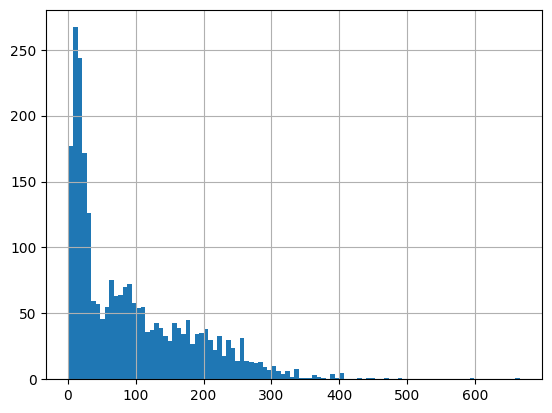

In [79]:
# distribution of number of cells in different wells
bulk_adata.obs['cell_count'].hist(bins=100)

## Cell count issue

In [10]:
bulk_adata

AnnData object with n_obs × n_vars = 2558 × 18211
    obs: 'SMILES', 'timepoint_hr', 'col', 'cell_id', 'donor_id', 'dose_uM', 'sm_name', 'well', 'cell_type', 'row', 'library_id', 'sm_lincs_id', 'control', 'plate_name'

In [ ]:
plate_name_update = {
    'plate_0': 'plate_2',
     'plate_1': 'plate_3',
     'plate_2': 'plate_1',
     'plate_3': 'plate_4',
     'plate_4': 'plate_0',
     'plate_5': 'plate_5',
}

bulk_adata.obs['plate_name'] = bulk_adata \
    .obs['plate_name'] \
    .map(plate_name_update) \
    .astype('str')

## Running Limma

In [ ]:
import limma_utils
de_pert_cols = [
    'sm_name',
    'sm_lincs_id',
    'SMILES',
    'dose_uM',
    'timepoint_hr',
    'cell_type',
]

control_compound = 'Dimethyl Sulfoxide'

def _run_limma_for_cell_type(bulk_adata):
    bulk_adata = bulk_adata.copy()
    
    compound_name_col = de_pert_cols[0]
    
    # limma doesn't like dashes etc. in the compound names
    rpert_mapping = bulk_adata.obs[compound_name_col].drop_duplicates() \
        .reset_index(drop=True).reset_index() \
        .set_index(compound_name_col)['index'].to_dict()
    
    bulk_adata.obs['Rpert'] = bulk_adata.obs.apply(
        lambda row: rpert_mapping[row[compound_name_col]], 
        axis='columns',
    ).astype('str')

    compound_name_to_Rpert = bulk_adata.obs.set_index(compound_name_col)['Rpert'].to_dict()
    ref_pert = compound_name_to_Rpert[control_compound]
            
    random_string = binascii.b2a_hex(os.urandom(15)).decode()
    
    
    limma_utils.limma_fit(
        bulk_adata, 
        design='~0+Rpert+donor_id+plate_name+row',
        output_path=f'output/{random_string}_limma.rds',
        plot_output_path=f'output/{random_string}_voom',
        exec_path='limma_fit.r',
    )

    pert_de_dfs = []
    


    for pert in bulk_adata.obs['Rpert'].unique():
        if pert == ref_pert:
            continue

        pert_de_df = limma_utils.limma_contrast(
            fit_path=f'output/{random_string}_limma.rds',
            contrast='Rpert'+pert+'-Rpert'+ref_pert,
            exec_path='limma_contrast.r',
        )

        pert_de_df['Rpert'] = pert

        pert_obs = bulk_adata.obs[bulk_adata.obs['Rpert'].eq(pert)]
        for col in de_pert_cols:
            pert_de_df[col] = pert_obs[col].unique()[0]
        pert_de_dfs.append(pert_de_df)

    de_df = pd.concat(pert_de_dfs, axis=0)

    try:
        os.remove(f'output/{random_string}_limma.rds')
        os.remove(f'output/{random_string}_voom')
    except FileNotFoundError:
        pass
    
    return de_df

run_limma_for_cell_type = delayed(_run_limma_for_cell_type)
cluster = LocalCluster(
    n_workers=6,
    processes=True,
    threads_per_worker=1,
    memory_limit='20GB',
)

c = Client(cluster)

In [ ]:

cell_types = bulk_adata.obs['cell_type'].unique()
de_dfs = []

for cell_type in cell_types:
    cell_type_selection = bulk_adata.obs['cell_type'].eq(cell_type)
    cell_type_bulk_adata = bulk_adata[cell_type_selection].copy()
    
    de_df = run_limma_for_cell_type(cell_type_bulk_adata)
    
    de_dfs.append(de_df)

de_dfs = c.compute(de_dfs, sync=True)
de_df = pd.concat(de_dfs)

We compute DE for each cell type independently. Using Dask, we execute the DE expression function for each cell type in parallel.

## Converting DataFrame to Anndata

In [ ]:
# def convert_de_df_to_anndata(de_df_copy, pert_cols, de_sig_cutoff):
pert_cols = de_pert_cols
de_sig_cutoff = 0.05
de_df_copy = de_df.copy()
zero_pval_selection = de_df_copy['P.Value'].eq(0)
print('number of cases with zero p value:', zero_pval_selection.sum())
de_df_copy.loc[zero_pval_selection, 'P.Value'] = np.finfo(np.float64).eps

de_df_copy['sign_log10_pval'] = np.sign(de_df_copy['logFC']) * -np.log10(de_df_copy['P.Value'])
de_df_copy['is_de'] = de_df_copy['P.Value'].lt(de_sig_cutoff)
de_df_copy['is_de_adj'] = de_df_copy['adj.P.Val'].lt(de_sig_cutoff)

de_feature_dfs = {}
for feature in ['is_de', 'is_de_adj', 'sign_log10_pval', 'logFC', 'P.Value', 'adj.P.Val']:
    df = de_df_copy.reset_index().pivot_table(
        index=['gene'], 
        columns=pert_cols,
        values=[feature],
        dropna=True,
    )
    de_feature_dfs[feature] = df


In [ ]:
df_copy = de_feature_dfs['sign_log10_pval'].T.copy()
df_copy.index = df_copy.index.to_frame(index=False).drop(columns=[0])

In [ ]:
gene_names = de_feature_dfs['sign_log10_pval'].index
X = de_feature_dfs['sign_log10_pval'].T[gene_names].values
obs = de_feature_dfs['sign_log10_pval'].T.index.to_frame(index=False).drop(columns=[0])
var = pd.DataFrame(index=gene_names)
de_adata = ad.AnnData(X, dtype=np.float64, obs=obs,var=var)
# de_adata.obs = de_adata.obs.reset_index()
# de_adata.obs = de_adata.obs.drop(columns=['level_0'])
# de_adata.obs.index = de_adata.obs.index.astype('string')

de_adata.layers['is_de'] = de_feature_dfs['is_de'].to_numpy().T
de_adata.layers['is_de_adj'] = de_feature_dfs['is_de_adj'].to_numpy().T
de_adata.layers['logFC'] = de_feature_dfs['logFC'].to_numpy().T
de_adata.layers['P.Value'] = de_feature_dfs['P.Value'].to_numpy().T
de_adata.layers['adj.P.Val'] = de_feature_dfs['adj.P.Val'].to_numpy().T
    
    # return de_adata
# de_adata = convert_de_df_to_anndata(de_df, de_pert_cols, 0.05)

## Validation

Let's make sure that the DE object we've computed has the exact same values as the DE object obtained from `de_train.parquet`

In [ ]:
kaggle_train_de_df = pd.read_parquet(os.path.join(data_dir, 'de_train.parquet'))
kaggle_train_de_df = kaggle_train_de_df.set_index(list(kaggle_train_de_df.columns[:5]))
obs = kaggle_train_de_df.index.to_frame(index=False)
var = pd.DataFrame(index=kaggle_train_de_df.columns)
kaggle_train_de_adata = ad.AnnData(kaggle_train_de_df.values, obs=obs, var=var, dtype=np.float64)
# kaggle_train_de_adata.obs = kaggle_train_de_adata.obs.reset_index()
# kaggle_train_de_adata.obs.index = kaggle_train_de_adata.obs.index.astype('str')

In [ ]:
sorting_index = kaggle_train_de_adata.obs.sort_values(['sm_name', 'cell_type']).index
kaggle_train_de_adata = kaggle_train_de_adata[sorting_index].copy()

In [ ]:
kaggle_train_de_adata

In [ ]:
de_adata.obs.index = de_adata.obs.index.astype('str')

sorting_index = de_adata.obs.sort_values(['sm_name', 'cell_type']).index
de_adata = de_adata[sorting_index].copy()

In [ ]:
np.allclose(kaggle_train_de_adata.X, de_adata.X)

# Evaluate 

In [ ]:
de_adata

In [ ]:
bulk_adata.X==0